In [1]:
import sys
sys.path.append("../../") # add top-level to import path search
from lib import model as gplib
from lib import runner
# from lib.dataset import MNIST
import torch.utils.data
from torch.utils.data import DataLoader

First, load train, validation and test dataloaders

In [2]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Generate synthetic data with f(x, y) = (x+y)^2
np.random.seed(42)  # for reproducibility
num_samples = 1000

# Generate random input points (x, y) from -1 to 1
x = np.random.uniform(-1, 1, num_samples)
y = np.random.uniform(-1, 1, num_samples)


# Compute target values: f(x, y) = (x+y)^2
targets = (x+y)**2

# Reshape inputs
inputs = np.vstack((x, y)).T

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(inputs)
y_tensor = torch.FloatTensor(targets).reshape(-1, 1)

# Split data into train, validation, and test sets
train_size = int(0.7 * num_samples)
val_size = int(0.15 * num_samples)
test_size = num_samples - train_size - val_size

X_train = X_tensor[:train_size]
y_train = y_tensor[:train_size]

X_val = X_tensor[train_size:train_size+val_size]
y_val = y_tensor[train_size:train_size+val_size]

X_test = X_tensor[train_size+val_size:]
y_test = y_tensor[train_size+val_size:]

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create dataloaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 700
Validation samples: 150
Test samples: 150


Text(0.5, 0.92, '3D Visualization of Target Function')

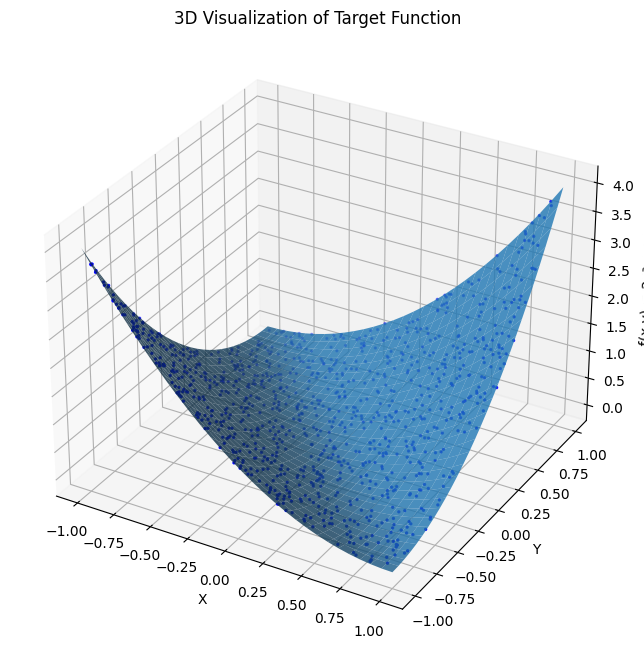

In [3]:
# Create a 3D visualization of the function
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a grid of x and y values
x_grid, y_grid = np.meshgrid(np.linspace(-1, 1, 30), np.linspace(-1, 1, 30))
z_grid = (x_grid+y_grid)**2  # The target function


# Plot the surface
surface = ax.plot_surface(x_grid, y_grid, z_grid, alpha=0.8)

# Plot the data points
ax.scatter(x, y, targets, c='blue', marker='o', s=2)

# Add labels and a colorbar
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(x,y) = 2x² + y²')
ax.set_title('3D Visualization of Target Function')

Load an existing model

In [4]:
# model = gplib.GP_Model(saveload_path="model80k.pt")
# model.print_model()


Test the model

In [5]:
# runner.test_model(test_dataloader, model, use_gpu=True)

Example MNIST images and model prediction

In [6]:
# import matplotlib.pyplot as plt
# import numpy as np
# np.set_printoptions(suppress=True, precision=3)
# inputs, labels = next(iter(test_dataloader))
# inputs = inputs.cuda()
# labels = labels.cuda()
# predictions = model.predict(inputs)

# fig, axes = plt.subplots(1, 3)
# for i in range(3):
#     axes[i].imshow(inputs[i].cpu())
#     pred = predictions.mean[i].detach().cpu().numpy()
#     true_label = np.argmax(labels[i].detach().cpu().numpy())
#     pred_max = np.argmax(pred)
#     axes[i].set_title(
#         f"true label: {true_label}\n"
#         f"model prediction: {pred_max}\n"
#         f"raw model mean:\n{pred[:5]}\n{pred[5:]}\n",
#         ha="left",
#         loc="left",
#     )

# fig.set_figwidth(10)
# fig.set_figheight(5)
# fig.tight_layout()

Train a new model

In [7]:
# model = gplib.GP_Model(
#     [
#         gplib.GP_conv2D(28, 28, 1, 3, kernel_size=4, stride=2, num_gp_pts=10, use_double_layer=True),
#         gplib.NormaliseGaussian(),
#         gplib.GP_conv2D(13, 13, 3, 3, kernel_size=4, stride=2, num_gp_pts=10, use_double_layer=True),
#         gplib.NormaliseGaussian(),
#         gplib.ReshapeGaussian([-1, 75]),
#         gplib.LayerFused(75, 10, num_gp_pts=10),
#         gplib.NormaliseGaussian(),
#         gplib.LayerFused(10, 10, num_gp_pts=10),
#     ],
#     saveload_path="model.pt",
# )

model = gplib.GP_Model(
    [   
        gplib.LayerFused(2, 2, num_gp_pts=10),
        gplib.NormaliseGaussian(),
        gplib.LayerFused(2, 1, num_gp_pts=10),
    ],
    saveload_path="model_test02_02.pt",
)
np.random.seed(42)  # for reproducibility
runner.train_model(
    train_dataloader, val_dataloader, model, epochs=500, learning_rate=1e-3, use_gpu=False, # True,
    pretrain=False,# True,
    global_jitter=1e-2, baseline_jitter=1e-2
)
model.save_model() # optionally save the model after training

epoch 0  , train negloglik: 27.12623,    val negloglik: 10.93267    accuracy: 2.0400 lr: [0.001]
epoch 1  , train negloglik: 9.56955,    val negloglik: 6.39853    accuracy: 0.6466 lr: [0.0009000000000000001]
epoch 2  , train negloglik: 5.94670,    val negloglik: 4.02021    accuracy: 0.6233 lr: [0.0009000000000000001]
epoch 3  , train negloglik: 3.60785,    val negloglik: 2.52280    accuracy: 0.9550 lr: [0.0009000000000000001]
epoch 4  , train negloglik: 1.92685,    val negloglik: 1.39519    accuracy: 0.6170 lr: [0.0009000000000000001]
epoch 5  , train negloglik: 1.34389,    val negloglik: 1.08478    accuracy: 0.5990 lr: [0.0009000000000000001]
epoch 6  , train negloglik: 1.12190,    val negloglik: 1.02001    accuracy: 0.5635 lr: [0.0009000000000000001]
epoch 7  , train negloglik: 1.06326,    val negloglik: 0.97572    accuracy: 0.5450 lr: [0.0009000000000000001]
epoch 8  , train negloglik: 1.03062,    val negloglik: 0.95422    accuracy: 0.5279 lr: [0.0009000000000000001]
epoch 9  , trai

In [8]:
model.print_model()

GP_Model(
  (layer_0): LayerFused(in=2 out=2 gp_pts_per_neuron=10)
  (layer_1): NormaliseGaussian()
  (layer_2): LayerFused(in=2 out=1 gp_pts_per_neuron=10)
)
parameter count:  139


In [9]:
print([layer[0] for layer in model.named_parameters()])

['input_noise_log', 'layer_0.z', 'layer_0.h', 'layer_0.l', 'layer_0.s', 'layer_0.jitter', 'layer_2.z', 'layer_2.h', 'layer_2.l', 'layer_2.s', 'layer_2.jitter']


```
   output:       y1                      ←出力
                  |             
                 (+)--------------
                  |              | 
                 (N1)           (N2)
                  |              | 
                 y1              y2           ←2層
                  |              |
                 (+)----------  (+)----------
                  |          |   |          |
                 (N1)       (N2) (N1)       (N2)
                  |          |   |          |
    Input:        x1         x2  x1         x2  ←1層

```

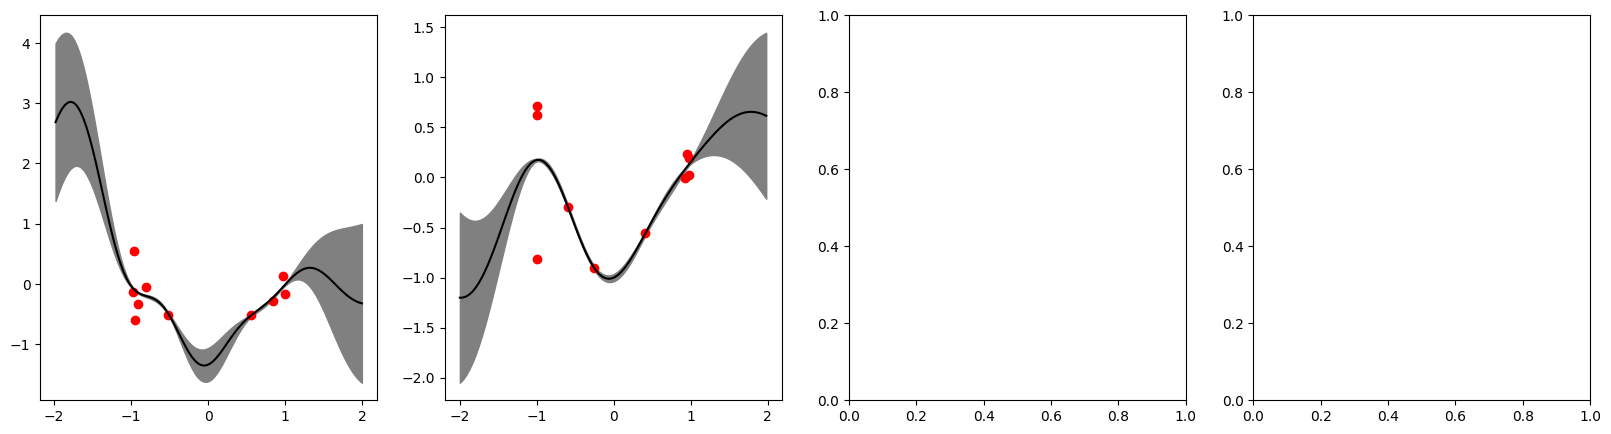

In [ ]:
# 1層目
model.layers[0].save_fig("./outputs/layer_fused1.png")

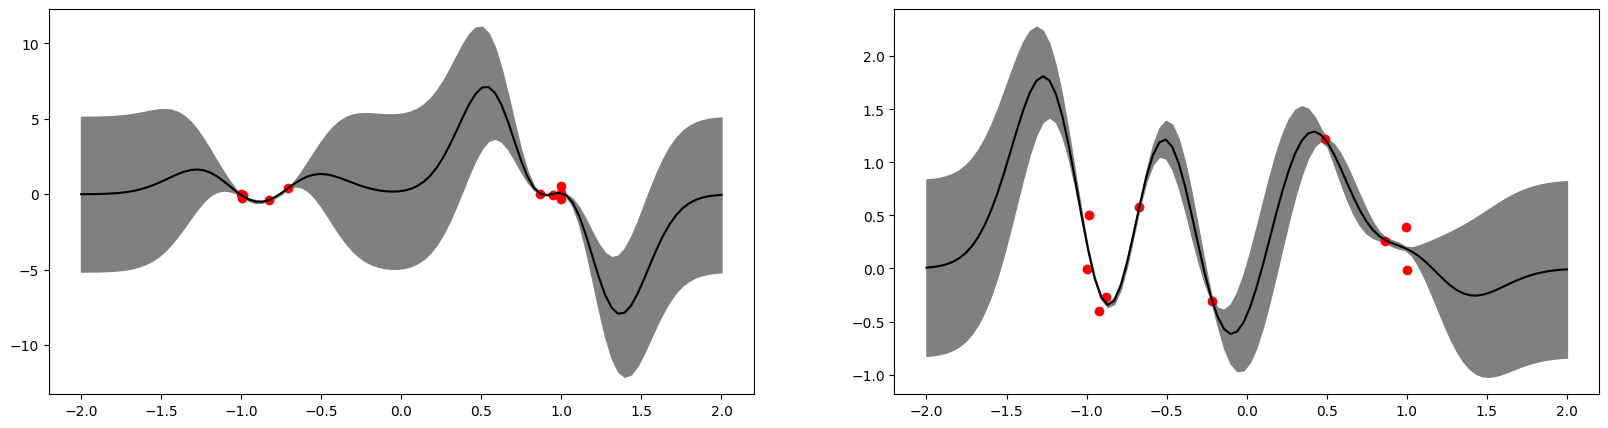

In [14]:
# 2層目
model.layers[2].save_fig("./outputs/layer_fused2.png")


In [11]:
model.layers[0]

LayerFused(in=2 out=2 gp_pts_per_neuron=10)

MSE: 0.339945
RMSE: 0.583048


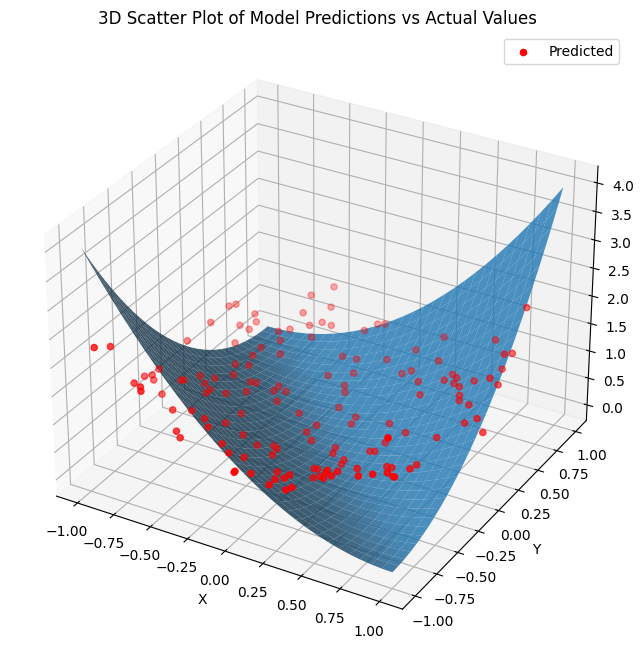

In [12]:
# Make predictions on the test set
X_test_tensor = X_test  # X_test is already a tensor
with torch.no_grad():
    predictions = model.predict(X_test_tensor)

# Create a 3D scatter plot of predictions vs actual values
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
# ax.scatter(X_test[:, 0].numpy(), X_test[:, 1].numpy(), y_test.numpy(), c='blue', marker='o', label='Actual')
ax.scatter(X_test[:, 0].numpy(), X_test[:, 1].numpy(), predictions.mean.numpy(), c='red', marker='o', label='Predicted')
# Plot the surface
surface = ax.plot_surface(x_grid, y_grid, z_grid, alpha=0.8)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot of Model Predictions vs Actual Values')
ax.legend()

# Calculate and print metrics
mse = torch.mean((predictions.mean - y_test)**2).item()
rmse = torch.sqrt(torch.mean((predictions.mean - y_test)**2)).item()
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")